# 0. Starts at 19:44:07

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [2]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [3]:
import random
from PIL import Image

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

image_path_list = list(image_path.rglob("*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

im = Image.open(random_image_path.as_posix())
im.height, im.width, image_class

(512, 512, 'pizza')

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from matplotlib import pyplot as plt

## Build image transformer

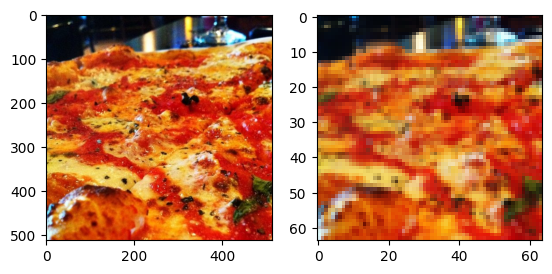

In [5]:
data_transform = transforms.Compose(
        [
            transforms.Resize(size=(64, 64)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor()
            ]
        )
plt.subplot(1, 2, 1).imshow(im)
plt.subplot(1, 2, 2).imshow(data_transform(im).permute(1, 2, 0).cpu())

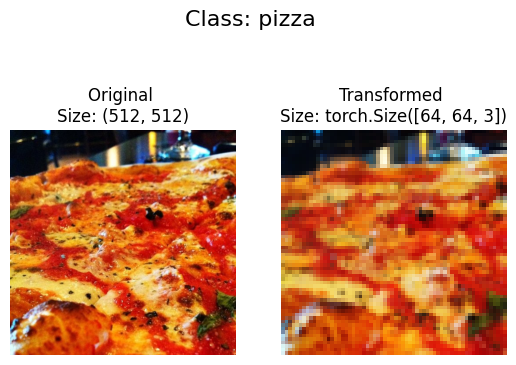

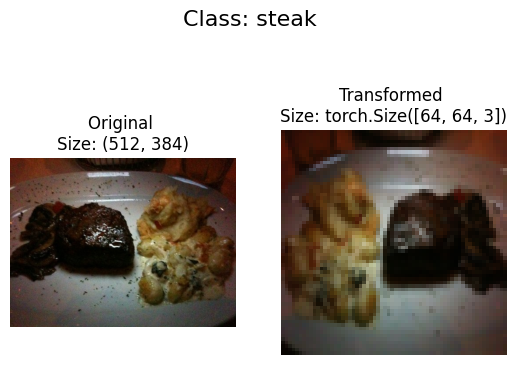

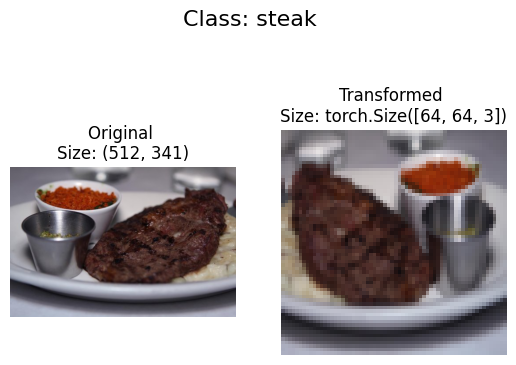

In [6]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(
        image_path_list,
        transform=data_transform,
        n=3
        )

# 1. Dataset creation

## Use `torchvision.datasets.ImageFolder` to create the dataset

In [7]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_dataset = ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

## Use `Dataset`

In [8]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

# 2. Augmentation

In [9]:
from torchvision import transforms

s_r_s = 64
standard_im_size = (s_r_s, s_r_s)

train_transforms = transforms.Compose(
        [
            transforms.Resize(size=standard_im_size),
            transforms.TrivialAugmentWide(num_magnitude_bins=31),
            transforms.ToTensor()
            ]
        )

test_transforms = transforms.Compose(
        [
            transforms.Resize(size=standard_im_size),
            transforms.ToTensor()
            ]
        )

# 3. TinyVGG without augmentation  

## 3.1 Simple transformer 

In [10]:
simple_transform = transforms.Compose(
        [
            transforms.Resize(size=standard_im_size),
            transforms.ToTensor()
            ]
        )

## 3.2 Dataloader

In [11]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataset = ImageFolder(root=train_dir, transform=simple_transform, target_transform=None)
test_dataset = ImageFolder(root=test_dir, transform=simple_transform, target_transform=None)

train_dataloader_simple = DataLoader(
        dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
        )
test_dataloader_simple = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## 3.3 TinyVGG

In [12]:
from torch import nn
from torchinfo import summary


class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
                nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
                nn.ReLU(),
                nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
                )
        self.conv_block_2 = nn.Sequential(
                nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
                nn.ReLU(),
                nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
                )
        self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(in_features=hidden_units * 13 * 13, out_features=output_shape)
                )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))


device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(RANDOM_SEED)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_dataset.classes)).to(device=device)

In [13]:
summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 3.4 Train | Test loop

In [14]:
torch.device

torch.device

In [16]:
import pandas as pd

from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        accuracy_fn: callable = accuracy_score,
        device: torch.device = device
        ) -> tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred_logits = model(X)

        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred_class)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


def test_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        accuracy_fn: callable = accuracy_score,
        device: torch.device = device
        ) -> tuple[float, float]:

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred_class)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        return test_loss, test_acc


def train_loop(
        epochs: int,
        model: nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        accuracy_fn: callable = accuracy_score,
        device: torch.device = device
        ) -> pd.DataFrame:
    
    results = {
        "train_loss": [],
        "train_acc" : [],
        "test_loss" : [],
        "test_acc"  : []
        }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
                model=model,
                dataloader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn,
                device=device
                )
        test_loss, test_acc = test_step(
                model=model,
                dataloader=test_dataloader,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                device=device
                )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    results = pd.DataFrame.from_dict(data=results)
    return results

In [17]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_dataset.classes)).to(device=device)

model_0_res_df: pd.DataFrame = train_loop(
        epochs=5,
        model=model_0,
        train_dataloader=train_dataloader_simple,
        test_dataloader=test_dataloader_simple,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(params=model_0.parameters(), lr=0.001),
        accuracy_fn=accuracy_score,
        device=device
        )

 20%|██        | 1/5 [01:14<04:56, 74.03s/it]


KeyboardInterrupt: 

In [19]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_data = ImageFolder(root=train_dir, transform=simple_transform, target_transform=None)
test_data = ImageFolder(root=test_dir, transform=simple_transform, target_transform=None)

train_dataloader_simple = DataLoader(
        dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
        )
test_dataloader_simple = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.4924
Epoch: 4 | train_loss: 1.0844 | train_acc: 0.3984 | test_loss: 1.0608 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0663 | train_acc: 0.4141 | test_loss: 1.0654 | test_acc: 0.5644
Total training time: 304.587 seconds


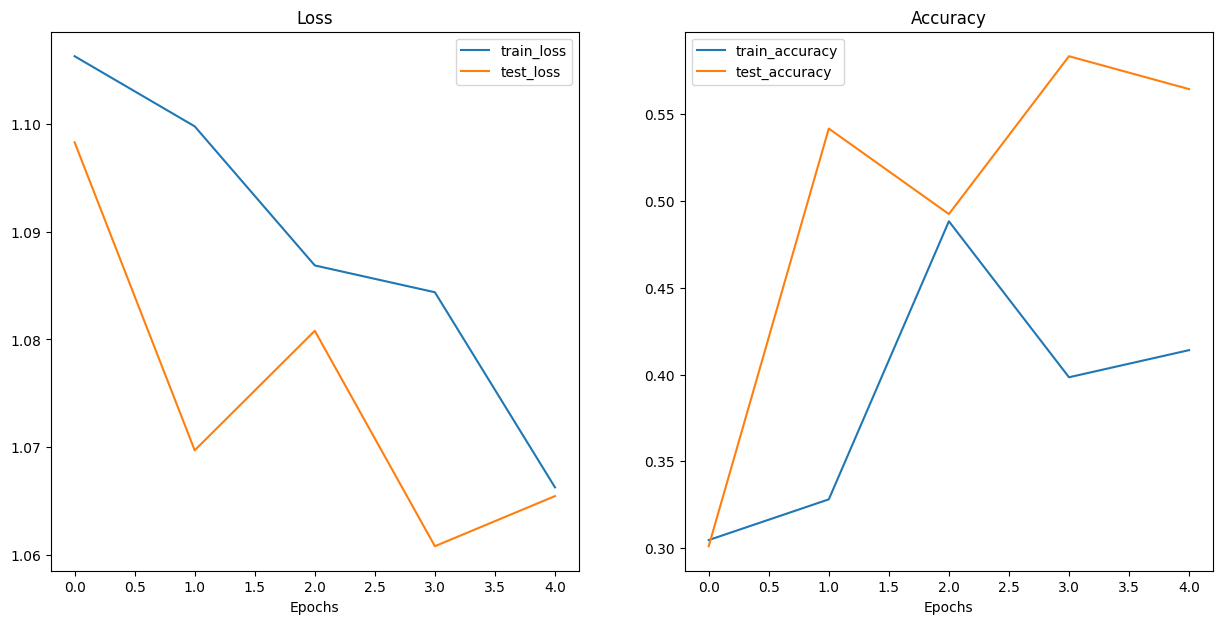

In [23]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_0_results)

# 4. TinyVGG with augmented data

## 4.1 Transformer with `TrivialAugmentWide`

In [25]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

## 4.2 Datasets and data loaders

In [28]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

In [31]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)


## 4.3 Training the model

In [33]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)

# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1045 | train_acc: 0.2500 | test_loss: 1.1016 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0760 | train_acc: 0.4258 | test_loss: 1.1316 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0730 | train_acc: 0.4258 | test_loss: 1.1704 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1220 | train_acc: 0.3047 | test_loss: 1.1541 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0734 | train_acc: 0.4648 | test_loss: 1.1494 | test_acc: 0.3021
Total training time: 307.125 seconds
